In [1]:
# Connect to ipython cluster and toggle on automatic parallel execution on the cluster. If the cluster has not been
# configured, comment out this cell. The code will then run on the local single-core kernel.
#from ipyparallel import Client
#rc = Client(profile='mpi')
#%autopx

In [1]:
# Redirect stdout to file mecana.log
import config
config.stdout_to_file = True

from dataccess import xrd
from dataccess import query
from dataccess import utils
import matplotlib.pyplot as plt
import numpy as np

# Configure notebook graphics
#%matplotlib inline
#import mpld3
#from mpld3 import plugins
#mpld3.enable_notebook() 

#from plotly.offline import init_notebook_mode, iplot_mpl
#init_notebook_mode()

# Disable deprecation warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
def get_query_dataset(querystring, alias = None, print_enable = True):
    dataset = query.main(querystring.split(), label = alias)
    if utils.isroot() and print_enable:
        print "Runs: ", dataset.runs
    return dataset

def get_query_label(*args, **kwargs):
    return get_query_dataset(*args, **kwargs).label

def run_xrd(query_labels, optionstring = '', bsub = False):
    prefix_sc = 'mecana.py xrd quad2 -l '
    labelstring = ' '.join(query_labels)
    print prefix_sc, labelstring, optionstring
    if bsub:
        import os
        os.system('bsub -n 8 -a mympi -q psanaq -o batch_logs/%%J.log mecana.py -n xrd quad2 -l %s %s' % \
                  (labelstring, optionstring))
    else:
        #%px %run mecana.py -n xrd quad2 -l $labelstring $optionstring
        from dataccess import xrd
        %run $prefix_sc $labelstring $optionstring
        
def plot_xrd(query_labels, compound_list, normalization = 'peak', plot_progression = False, bgsub = False, plot_patterns = False):
    if plot_progression and not plot_patterns:
        x = xrd.XRD(['quad2'], query_labels,  compound_list = compound_list, bgsub = bgsub, normalization = normalization,\
            plot_progression = True, plot_peakfits = False)
        x.plot_progression(show = True)
    elif plot_patterns and not plot_progression:
        x = xrd.XRD(['quad2'], query_labels,  compound_list = compound_list, bgsub = bgsub, normalization = normalization,\
            plot_progression = False, plot_peakfits = True)
        x.plot_patterns()
        xrd.plt.show()
    else: # plot both
        x = xrd.XRD(['quad2'], query_labels,  compound_list = compound_list, bgsub = bgsub, normalization = normalization,\
            plot_progression = False, plot_peakfits = True)
        x.plot_patterns()
        x.plot_progression(show = True)

In [3]:
def make_summary_table():
    from IPython.display import HTML, display

    def display_table(title, data):
         display(HTML(
            '<h2>%s</h2>' % title +
            '<table><tr>{}</tr></table>'.format(
                '</tr><tr>'.join(
                    '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
                )
         ))

    table_materials = ['Fe3O4', 'Fe3O4HEF', 'MgO', 'MgOHEF', 'Graphite']
    table_materials_labels = ['Fe$_{3}$O$_4$ ref', 'Fe$_3$O$_4$ HEF', 'MgO ref', 'MgO HEF', 'Graphite ref']
    table_headings = ['1C short pulse', '1C long pulse', '2C short delay (< 70 fs)', '2C long delay (> 70 fs)']

    def get_row_datasets(material):
        """
        Return list of datasets corresponding to each cell in one row of the table
        """
        def merge_queries(query_string_list):
            dsets = [get_query_dataset(q, print_enable=False) for q in query_string_list]
            if len(dsets) == 1:
                return dsets[0]
            elif len(dsets) == 2:
                label_combined = ''.join(map(lambda x: x.label, dsets))
                return dsets[0].union(dsets[1], label_combined)

        querystring_lists =\
            [['material %s runs 870 961' % material, 'material %s runs 1071 1136' % material],
             ['material %s runs 1016 1070' % material],
            ['material %s runs 0 870 delay 0 80' % material],
            ['material %s runs 0 870 delay 80 200' % material]]
        datasets = map(merge_queries, querystring_lists)
        #print 'output:'
        result = [ds.runs for ds in datasets]
        return result
        #for ds in datasets:
        #    print ds.runs

    def get_row_numbers(material):
        return np.array(map(len, get_row_datasets(material)))

    col1 = np.array([''] + table_materials_labels)[:, np.newaxis]
    rest = np.vstack(((np.array(table_headings)), np.array(map(get_row_numbers, table_materials))))
    table = np.hstack((col1, rest))
    display_table('LK20: breakdown of runs by type', table)

## LK20 analysis

In [9]:
make_summary_table()

In [16]:
from dataccess import logbook
from itertools import *
from collections import namedtuple
from dataccess import utils
import pdb

def accumulate(operator, initial, sequence):
    if not sequence:
        return initial
    return operator(sequence[0], accumulate(operator, initial, sequence[1:]))
def accumulate_sum(sequence):
    def operator(elt, lst):
        if not lst:
            return [elt]
        return [elt + lst[0]] + lst
    return accumulate(operator, [], sequence[::-1])[::-1]
accumulate_sum(range(10))

@utils.memoize(None)
def filter_flux(label):
    try:
        return bool(logbook.get_label_attribute(label, 'focal_size') and logbook.get_label_attribute(label, 'transmission'))
    except:
        return False
    
Run = namedtuple('Run', ['run', 'group', 'focal_size', 'transmission'])
    
def partition_runs(dataset):
    """
    Return a list of tuples containing start and end values of ranges
    of run numbers that partition the dataset into consecutive sequences
    of runs with non-descending focal spot sizes.
    """
    runs = map(int, filter(filter_flux, map(str, dataset.runs)))
    focal_sizes = [logbook.get_label_attribute(r, 'focal_size') for r in filter(filter_flux, runs)]
    transmissions = [logbook.get_label_attribute(r, 'transmission') for r in filter(filter_flux, runs)]
    
    def new_group(index):
        if index >= len(runs) - 1 or index == 0:
            return 0
        else:
            return int(runs[index] - runs[index - 1] > 10)
    groups = accumulate_sum(map(new_group, range(len(focal_sizes))))
    
    run_tuples = [Run(run, group, focal_size, transmission) for run, group in zip(runs, groups, focal_sizes, transmissions)]
    
    groups = groupby(run_tuples, lambda rt: rt.group)
    return [[rt for rt in rts] for _, rts in groups]

    #groupby(run_tuples, lambda rt: rt.group)
def get_progressions(dataset):
    """
    Return list of groups of run numbers of at least two runs.
    
    A group is defined as a collection of run numbers with a maximum difference
    of 10 between a given run number and the element of the remaining values closest
    to it.
    """
    return filter(lambda runlist: len(runlist) > 1, partition_runs(dataset))

#focal_sizes = [logbook.get_label_attribute(r, 'focal_size') for r in filter(filter_flux, truns)]

In [11]:
fe_run_numbers = get_progressions(get_query_dataset('material Fe3O4 runs 870 1200'))

Runs:  [877, 888, 909, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181]


In [17]:
fe3o4 = get_query_dataset('material Fe3O4 runs 870 1200')

Runs:  [877, 888, 909, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181]


In [7]:
Fe_ref_short = [get_query_dataset('material Fe3O4 runs 876 961 transmission 1 focal_size %d' % spotsize,\
                                'Fe3O4.ref.1C.%sum' % spotsize).label for spotsize in [2, 4, 8, 18, 28, 48]]
Fe_ref_short

Runs:  [909, 949]
Runs:  [948]
Runs:  [947]
Runs:  [946]
Runs:  [945]
Runs:  [941, 942]


['Fe3O4.ref.1C.2um',
 'Fe3O4.ref.1C.4um',
 'Fe3O4.ref.1C.8um',
 'Fe3O4.ref.1C.18um',
 'Fe3O4.ref.1C.28um',
 'Fe3O4.ref.1C.48um']

### Fe<sub>3</sub>O<sub>4</sub> ref short pulse, one color: first attempt
1. Background subtraction via 2D spline interpolation
2. Powder patterns normalized to integral of the background
3. $I_{hkl}$ evaluated by simple integration of peaks in the resulting pattern 

### Fe<sub>3</sub>O<sub>4</sub> ref short pulse, one color: first attempt

Query data by attribute values:

In [4]:
Fe_ref_long =\
[get_query_dataset('material Fe3O4 runs 1016 1070 transmission 1 focal_size %d' % spotsize,\
        'Fe3O4.ref.1C.long.%sum' % spotsize).label for spotsize in [2, 4, 8, 18, 28, 48]]
print Fe_ref_long

Runs:  [1043]
Runs:  [1042]
Runs:  [1041]
Runs:  [1040]
Runs:  [1039]
Runs:  [1035, 1036]
['Fe3O4.ref.1C.long.2um', 'Fe3O4.ref.1C.long.4um', 'Fe3O4.ref.1C.long.8um', 'Fe3O4.ref.1C.long.18um', 'Fe3O4.ref.1C.long.28um', 'Fe3O4.ref.1C.long.48um']


### Fe<sub>3</sub>O<sub>4</sub> ref short pulse, one color: first attempt

In [8]:
plot_xrd(Fe_ref_short, compound_list = ['Fe3O4'],
    normalization = 'background', plot_patterns = True, bgsub = True)

### Fe<sub>3</sub>O<sub>4</sub> ref short pulse, one color: first attempt

In [9]:
plot_xrd(Fe_ref_short, compound_list = ['Fe3O4'],
    normalization = 'background', bgsub = True, plot_progression = True)

Two problems:
1. Background subtraction introduces artifacts that throw off peak integration in certain datasets.
2. Normalization across datasets is inadequate, resulting in spurious variations in relative Bragg peak intensities.

New approach: fit each peak to Gaussian + linear background. 

* This obviates the need for background subtraction in most cases. 
* Doesn't address the lack of normalization; however, we can normalize each powder pattern by the intensity of its lowest-order peak. 
* Causes us to lose a degree of freedom but at least allows us to physically intrepret progressions of Bragg peak intensities. 

### Fe<sub>3</sub>O<sub>4</sub> ref short pulse, one color with peak-fitting

In [10]:
plot_xrd(Fe_ref_short, compound_list = ['Fe3O4'],
         normalization = 'peak', plot_patterns = True)

### Fe<sub>3</sub>O<sub>4</sub> ref short pulse, one color with peak-fitting and normalization to lowest-order peak.

In [11]:
plot_xrd(Fe_ref_short, compound_list = ['Fe3O4'],
         normalization = 'peak', plot_progression = True)

In [ ]:
x = xrd.XRD(['quad2'], Fe_ref_short[:2],  compound_list = ['Fe3O4'], bgsub = False, normalization = 'peak',\
            plot_progression = True, plot_peakfits = False)
x.plot_progression(show = True)

In [8]:
plot_xrd(Fe_ref_long, compound_list = ['Fe3O4'], normalization = 'peak', plot_patterns = True)

### Fe3O4 ref long pulse, one color

In [12]:
Fe_ref_long = [get_query_dataset('material Fe3O4 runs 1016 1070 transmission 1 focal_size %d' % spotsize,\
                                'Fe3O4.ref.1C.long.%sum' % spotsize).label for spotsize in [2, 4, 8, 18, 28, 48]]
plot_xrd(Fe_ref_long, compound_list = ['Fe3O4'], normalization = 'peak', plot_progression = True)

Runs:  [1043]
Runs:  [1042]
Runs:  [1041]
Runs:  [1040]
Runs:  [1039]
Runs:  [1035, 1036]


### Fe3O4 ref 1C: tentative conclusions

* Small (< 5 percent) variations in $I_{hkl}/I_{200}$ as a function of incident flux for short pulse duration.
* Larger variations in the long pulse data, which is suggestive but needs more work to confirm.
* Possible agreement with LD67 for long pulse durations; i.e., an anomalous rise in the 222 peak (38.9 deg scattering angle).

In [8]:
plot_xrd(Fe_ref_long, compound_list = ['Fe3O4'], normalization = 'background', plot_progression = True)

### MgO

* Weaker signal, and fewer peaks, than Fe<sub>3</sub>O<sub>4</sub>. Used background subtraction on this data because the highest-order peak visible on quad2 is close to a sharp feature in the background that throws off peak fitting if it isn't removed.

* $\downarrow$ for data

In [14]:
MgO_ref_short2 = [get_query_dataset('material MgO runs 870 961 transmission .295 focal_size %d' % spotsize,
                                'MgO.ref.1C.short2.%sum' % spotsize, print_enable = True).label
                                for spotsize in [2, 8, 18, 28, 48]]

Runs:  [886]
Runs:  [889]
Runs:  [890]
Runs:  [891]
Runs:  [896, 897]


### MgO ref 1C

In [15]:
plot_xrd(MgO_ref_short2, compound_list = ['MgO'], normalization = 'peak', bgsub = True, plot_patterns = True)

### MgO ref 1C

In [16]:
plot_xrd(MgO_ref_short2, compound_list = ['MgO'], normalization = 'peak', bgsub = True, plot_progression = True)

Rise of the third peak at high fluence may be unphysical: background subtraction looks questionable

### Graphite ref 1C

* Most difficult dataset due to very small signal relative to variations in background level.
* No useful Bragg peak intensity progressions yet, but I haven't put much time into refine the background-subtraction and/or peak-fitting procedures.
* The graphite samples were very inhomogeneous, so doing event selection might be fruitful.

In [17]:
Graphite_ref_short = [get_query_dataset('material Graphite runs 1071 1136 transmission 1 focal_size %d' % spotsize,
                                'C.ref.1C.short.%sum' % spotsize, print_enable = False).label
                                for spotsize in [2, 4, 8, 18, 28, 48]]

In [18]:
plot_xrd(Graphite_ref_short, compound_list = ['Graphite'], normalization = 'peak', plot_patterns = True)

In [7]:
plot_xrd(Graphite_ref_short, compound_list = ['Graphite'], normalization = 'peak', plot_progression = True)

In [16]:
MgO_ref_short = [get_query_dataset('material MgO runs 870 961 transmission 1 focal_size %d' % spotsize,
                                'MgO.ref.1C.short.%sum' % spotsize, print_enable = True).label
                                for spotsize in [2, 4, 8, 18, 28, 48]]

Runs:  [878, 906]
Runs:  [911]
Runs:  [912]
Runs:  [913]
Runs:  [914]
Runs:  [918, 921]


In [15]:
MgO_ref_short2 = [get_query_dataset('material MgO runs 870 961 transmission .295 focal_size %d' % spotsize,
                                'MgO.ref.1C.short2.%sum' % spotsize, print_enable = True).label
                                for spotsize in [2, 8, 18, 28, 48]]

Runs:  [886]
Runs:  [889]
Runs:  [890]
Runs:  [891]
Runs:  [896, 897]


In [53]:
Graphite_ref_long_delay =\
        [get_query_dataset('material Graphite runs 100 870 transmission %s delay 80 200' % i,
        print_enable = True).label for i in [.1, 1]]
#plot_xrd(Graphite_ref_long_delay, compound_list = ['Graphite'], normalization = 'peak', plot_patterns = True)

Runs:  []
Runs:  [258, 259, 260, 261, 262, 324, 325, 326, 327, 328, 329]


In [ ]:
#MgO_ref_long_delay =\
#        [get_query_dataset('material MgO runs 100 870 transmission %s delay 80 200' % i,
#        print_enable = True).label for i in [.1, 1]]
#plot_xrd(MgO_ref_long_delay, compound_list = ['MgO'], normalization = 'peak', plot_patterns = True)

In [26]:
MgO_ref_short_delay =\
        [get_query_dataset('material MgO runs %s transmission 1 delay 0 80' % i,
        print_enable = True).label for i in ['541 545', '563 568']]

Runs:  [541, 542, 543, 544, 545]
Runs:  []


In [23]:
from dataccess import xrd
# Test peak-fitting for a single dataset
x = xrd.main(['quad2'], ['Fe3O4.ref.1C.2um'],  compound_list = ['Fe3O4'], bgsub = False, normalization = 'peak')

KeyboardInterrupt: 

2C XRD: a cursory view

MgO

In [4]:
plot_xrd(['MgOref_cold', 'MgOref_hot'], compound_list = ['MgO'], normalization = 'background', plot_patterns = True)

In [4]:
Fe3O4_2C_cold = [get_query_dataset('material Fe3O4 runs 700 750 focal_size 60').label]

Runs:  [742, 743, 744, 745, 746]


In [ ]:
ls

In [ ]:
Fe3O4_2C_ref_short_delay =\
        [get_query_dataset('material Fe3O4 runs 100 750 focal_size 5 transmission %s delay 0 50' % i, alias,
        print_enable = True).label for i, alias in zip([.1, 1], ['Fe3O4.ref.2C.short.0.1', 'Fe3O4.ref.2C.long.0.1'])]

In [26]:
Fe3O4_2C_ref_long_delay =\
        [get_query_dataset('material Fe3O4 runs 400 420 focal_size 5 transmission %s delay 80 200' % i,
        print_enable = True).label for i in [.1, 1]]

Runs:  [411, 412, 413, 414, 415, 416, 417, 418, 419, 420]
Runs:  [401, 402, 403, 404, 405, 406, 407, 408, 409, 410]


Fe<sub>3</sub>O<sub>4</sub> ref

In [10]:
plot_xrd(Fe3O4_2C_ref_short_delay, compound_list = ['Fe3O4'], normalization = 'peak', plot_patterns = True)

Peak intensity progressions for Fe3O4 and Graphite ref: still running... 

In [11]:
plot_xrd(Fe3O4_2C_ref_short_delay, compound_list = ['Fe3O4'], normalization = 'peak', plot_progression = True)

KeyboardInterrupt: 

plot_xrd(Fe3O4_2C_ref_long_delay, compound_list = ['Fe3O4'], normalization = 'peak', plot_patterns = True)

In [ ]:
plot_xrd(Fe3O4_2C_ref_long_delay, compound_list = ['Fe3O4'], normalization = 'peak', plot_progression = True)

### Next steps?

* Preliminary processing of HEF data
* Flag good/bad runs in a consistent way in the logging spreadsheet (or detect and reject bad datasets on the analysis software side)
* Quantify/establish bounds on perturbation due to the probe pulse in 2C mode.
* Decide on a criterion for 2C mode event selection (possibly based partially on the above)
* Refine peak fitting procedure
* Implement photon hit-detecting filter if necessary or useful for low-signal datasets
* Implement subtraction of bleed test runs from 2C data 

In [37]:
from dataccess import database
database.delete_collections(delete_logbook=True)
config.logbook_ID

'1DRtTTiatTbN2z4brGJxJ1OkWRMCj3gyoPfFRN5fvl3M'

Fe<sub>3</sub>O<sub>4</sub>:

In [4]:
plot_xrd(['Fe3O4_ref_cold', 'Fe3O4_ref_hot'], compound_list = ['Fe3O4'], normalization = 'peak', plot_patterns = True)

2C summary

* Fe<sub>3</sub>O<sub>4</sub> looks good, but Si spectrometer data is missing for a number of runs (763 to 770), which means we can't do event selection based on the pump/probe spectrum. 
* MgO cold data has very weak signal (only one perceptible peak in the averaged data). Do we need to do photon-counting?
* Graphite (not show in these slides) 

In [57]:
def batch_preprocess(run_number):
    import os
    os.system(r'bsub -n 1 -q psfehq -o batch_logs/%J.log ' + 'mecana.py -n datashow quad2 ' + str(run_number))

In [56]:
batchruns = get_query_dataset('runs 0 870 material dark').runs;

Runs:  [85, 89, 97, 127, 200, 340, 379, 436, 662]


In [58]:
map(batch_preprocess, batchruns);

In [9]:
@utils.ifroot
def testplot():
    f = plt.figure()
    plt.plot(range(10), label = 'test')
    plt.ylim(0, 8)
    plt.legend()
    plt.ylabel("How is this font? \n")
    plt.show()
    
testplot()

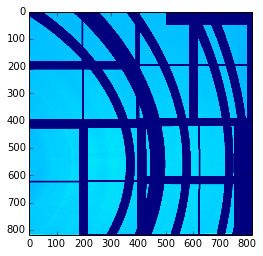

In [20]:
from dataccess.xrd import *
import matplotlib.pyplot as plt
tofit = np.load ('powder_with_cutout.npy')
plt.imshow(tofit)
plt.show()

Loading BokehJS ...

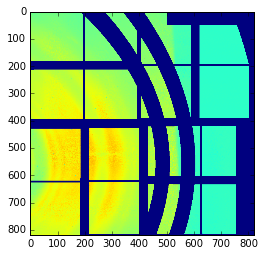

In [11]:
from dataccess.xrd import *
import matplotlib.pyplot as plt
tofit = np.load ('powder_with_cutout.npy')
plt.imshow(tofit)
plt.show()

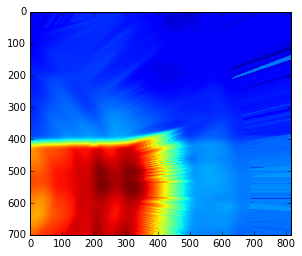

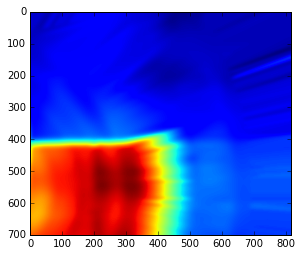

In [131]:
combined = np.where(np.isnan(c), bg1[1], c)
plt.imshow(combined[:700, :])
plt.show()
plt.imshow(gaussian_filter(combined, 5)[:700, :])
plt.show()

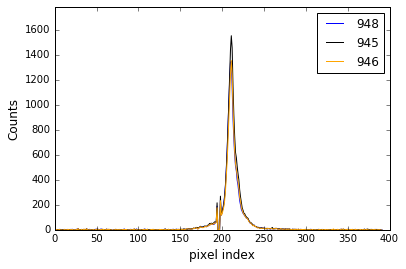

In [7]:
%run mecana.py spectrum -n xrts1 948 945 946